# Log


# Code Desc

* Local image registration



---

# Code Flow

### 1. Data preprocessing 
    * Voxel Morph model input을 맞추기 위한 과정

### 2. Voxel Morph Model build

### 3. Train

### 4. Inference step
    * Patch image reconstuction Step


---

# Package Import 

In [2]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm
import neurite as ne
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
import numpy as np
import pandas as pd
import cv2 as cv
import glob
import os
from scipy import ndimage
from IPython import display 
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
from ants import from_numpy, resample_image, registration, apply_transforms
import pydicom
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
tf.config.set_visible_devices(gpus[0], 'GPU') # using GPU1



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


---
# Variable & Path


In [3]:
Moving_phase = 'P'
fixed_phase  = 'A'
patch_size = 64


train_P = "/media/monib/ext1/work2022/Base_Dataset/vm_data_affine_p2a/input/train/example_A"
train_A = "/media/monib/ext1/work2022/Base_Dataset/vm_data_affine_p2a/input/train/example_B"
val_P = "/media/monib/ext1/work2022/Base_Dataset/vm_data_affine_p2a/input/val/example_A"
val_A = "/media/monib/ext1/work2022/Base_Dataset/vm_data_affine_p2a/input/val/example_B"

train_P_paths = [os.path.join(train_P, folder) for folder in os.listdir(train_P)]
train_A_paths = [os.path.join(train_A, folder) for folder in os.listdir(train_A)]
val_P_paths = [os.path.join(val_P, folder) for folder in os.listdir(val_P)]
val_A_paths = [os.path.join(val_A, folder) for folder in os.listdir(val_A)]


train_P_paths.sort()
train_A_paths.sort()
val_P_paths.sort()
val_A_paths.sort()

#
Train_num  = len(train_P_paths)
Val_num = len(val_P_paths)



# Utils function & Callback function

In [4]:
############################
# Result Analysis function #
############################

def get_2d_quiver(flow_2d, sp_factor = 20):
    """
    flow_2d: Flow filed in 2d+3 format. Example (512,512,3)
    sp_factor = sparsity factor.
    """
    spatial_flow = flow_2d[:, :, 0:2]
    meshg = meshgridnd_like(spatial_flow[::sp_factor, ::sp_factor, 0])
    mesh = np.asarray(meshg)
    mesh_mv = np.moveaxis(mesh, 0, -1)
    meshX = mesh_mv[:, :, 0]
    meshY = mesh_mv[:, :, 1]


    flowX_2d = flow_2d[::sp_factor, ::sp_factor, 0]
    flowY_2d = flow_2d[::sp_factor, ::sp_factor, 1]
    flowZ_2d = flow_2d[::sp_factor, ::sp_factor, 2]

    fig, ax = plt.subplots(figsize=(10,10))

    ax.quiver(meshX, meshY, flowX_2d, flowY_2d, flowZ_2d )
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect('equal')
    
    return fig

def meshgridnd_like(in_img, rng_func=range):
    new_shape = list(in_img.shape)
    all_range = [rng_func(i_len) for i_len in new_shape]
    return tuple([x_arr.swapaxes(0, 1) for x_arr in np.meshgrid(*all_range)])
def norm (array):
    array = (array-array.min())/(array.max() - array.min())
    return array


#######################
## Callback function ##
#######################

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


def plot_learning_curve(log_df,
                        loss_name='loss',
                        loo_idx=None,
                        ylim=(None, None),
                        logscale=False,
                        **kwargs):
    """
    """

    # Data from the log.csv
    epochs = np.arange(log_df.epoch.iloc[0] + 1, log_df.epoch.iloc[-1] + 2, 1, dtype=np.uint32)

    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=kwargs.get('fig_size', (9, 5)))

    if loo_idx is not None:
        plt.title(f'Learning Curves (Loss) (LOOCV: {loo_idx + 1})')
    else:
        plt.title(f'Learning Curves ({loss_name})')
    plt.xlabel('Epoch')  
    plt.ylabel('Loss')
    if logscale:
        plt.yscale('log')
        plt.grid(True, which='both')
    if ylim[0] is not None:
        plt.ylim(bottom=ylim[0])
    if ylim[1] is not None:
        plt.ylim(top=ylim[1])
    plt.plot(epochs, log_df[f'{loss_name}'], '-', label='Training')
    # plt.plot(epochs, log_df[f'val_{loss_name}'], '-', label='Validation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.style.use('seaborn-white')
    
def read_dicom_files(dicom_dir):
    try:
        dicom_files = glob.glob(os.path.join(dicom_dir, "*.*"))
        sorted_dicom_files = sorted(dicom_files)
        stacked_dicom = [pydicom.dcmread(dicom_file) for dicom_file in sorted_dicom_files]
        return stacked_dicom
    except IndexError as e:
        print(f"{e}, at path {dicom_dir}")
        return None

def create_3d(dicom_files):
    stacked_dicom = dicom_files  # stack of dicom files in a list

    image_shape = list(stacked_dicom[0].pixel_array.shape)
    image_shape.append(len(stacked_dicom))
    image_3d = np.zeros(image_shape)

    for j in range(len(stacked_dicom)):
        image_3d[:, :, j] = stacked_dicom[j].pixel_array

    return image_3d

def make_patches(image,patch_size= 64):
    stride = int(patch_size)

    image_patches = []
    locations = []
    for i in range(0, image.shape[0], stride):
        for j in range(0, image.shape[1], stride):
            Patch = np.zeros((patch_size,patch_size,192))
            Patch[Patch==0]= -1024/10000
            img_patch = image[i:i + patch_size,j:j + patch_size, :]

            Patch[: img_patch.shape[0],:img_patch.shape[1],:] = img_patch

            patch_img = Patch
            image_patches.append(patch_img)
            locations.append((i, j))

    patch_array = np.zeros((len(image_patches),patch_size,patch_size,image.shape[-1]))
    for idx in range(len(image_patches)):
        patch_array[idx,:,:,:] =image_patches[idx]
    return patch_array, locations


class LearningCurveCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        display.clear_output(wait=True)
        
        log_df = pd.read_csv(os.path.join(save_model_path, r'log_p2a.csv'))
        display.display(log_df[-20:])
        plot_learning_curve(log_df, loss_name = 'vxm_dense_flow_loss')
        plot_learning_curve(log_df, loss_name = 'vxm_dense_transformer_loss')
        plot_learning_curve(log_df,loss_name='loss')
        
        display.display(plt.gcf())

---
# 1. Data Load & Preprocessing

In [5]:
# Train_num = 4
# Val_num = 1

In [6]:
T_moving = np.zeros((512,512,192))
T_fixed  = np.zeros((512,512,192))

# for i in tqdm(range(Train_num)):
#     moving = create_3d(read_dicom_files(train_P_paths[i]))/10000
#     fixed = create_3d(read_dicom_files(train_A_paths[i]))/10000
#     T_moving[...,:moving.shape[-1]] = moving
#     T_fixed[...,:fixed.shape[-1]] = fixed
#
# # print("Training Moving Data info")
# # print(T_moving.shape)
# # print(T_moving.min())
# # print(T_moving.max())
# #
# # print("Training Fixed Data info")
# # print(T_fixed.shape)
# # print(T_fixed.min())
# # print(T_fixed.max())
#
#
# V_moving = np.zeros((512,512,192))
# V_fixed  = np.zeros((512,512,192))
#
# for i in tqdm(range(Val_num)):
#     moving = create_3d(read_dicom_files(val_P_paths[i]))/10000
#     fixed = create_3d(read_dicom_files(val_A_paths[i]))/10000
#     V_moving[...,:moving.shape[-1]] = moving
#     V_fixed[...,:fixed.shape[-1]] = fixed

# print("Val Moving Data info")
# print(V_moving.shape)
# print(V_moving.min())
# print(V_moving.max())
#
# print("Val Fixed Data info")
# print(V_fixed.shape)
# print(V_fixed.min())
# print(V_fixed.max())

# patch_save_path = f'./patch_data_{Moving_phase}_{fixed_phase}_{patch_size}'

# try:
#     os.makedirs(patch_save_path)
# except FileExistsError as err:
#     print(err)
# else:
#     print(patch_save_path)

# """
# FIXME: Double check this part
# """
patch_number = int((512/patch_size)*(512/patch_size))

# for i in tqdm(range(Train_num)):
#     # TODO: create single image and save it as an array of patches
#     moving = create_3d(read_dicom_files(train_P_paths[i]))/10000
#     fixed = create_3d(read_dicom_files(train_A_paths[i]))/10000
#     T_moving[...,:moving.shape[-1]] = moving
#     T_fixed[...,:fixed.shape[-1]] = fixed

#     moving_patches , _ = make_patches(T_moving,patch_size)
#     fixed_patches  , _ = make_patches(T_fixed,patch_size)

#     for j in range(patch_number):
#         moving = moving_patches[j:j+1]
#         fixed = fixed_patches[j:j+1]
#         np.savez(f'{patch_save_path}/{i*patch_number+j}.npz',moving=moving,fixed=fixed)


---

# 2. Voxel Morph Model build & Compile 

* Use losses : Ncc loss(1), Gradient loss(0.01) 

In [8]:
vol_shape = (64, 64, 192)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

print(vxm_model.input)
print(vxm_model.output)

[<KerasTensor: shape=(None, 64, 64, 192, 1) dtype=float32 (created by layer 'vxm_dense_source_input')>, <KerasTensor: shape=(None, 64, 64, 192, 1) dtype=float32 (created by layer 'vxm_dense_target_input')>]
[<KerasTensor: shape=(None, 64, 64, 192, 1) dtype=float32 (created by layer 'vxm_dense_transformer')>, <KerasTensor: shape=(None, 64, 64, 192, 3) dtype=float32 (created by layer 'vxm_dense_flow')>]


In [9]:
# Callback & weight save path
save_model_path = f'./model_p2a' 
checkpointer = callbacks.ModelCheckpoint(os.path.join(f'{save_model_path}','weights_{epoch:05d}_{loss:.4g}.h5'),save_weights_only=True)
csv_logger = callbacks.CSVLogger(f'{save_model_path}/log_p2a.csv', append=True)
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=40)
plot_learning_curves_epoch = LearningCurveCallback()

# Loss
losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss]
lambda_param = 0.01
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

In [13]:
def vxm_data_generator(data_number = 75*64, batch_size=128):
    
    while True:
        
        idx1 = np.random.randint(0, data_number, size=batch_size)

        data = np.load(f'/media/monib/ext1/work2022/Base_Dataset/affined_patch_data/patch_data_{Moving_phase}_{fixed_phase}_{patch_size}/{idx1[0]}.npz')

        moving_images = data['moving']
        fixed_images  = data['fixed']

        zero_phi = np.zeros([batch_size,*fixed_images.shape[1:4]])

        inputs = [moving_images, fixed_images]

        outputs = [fixed_images, zero_phi]

        yield inputs, outputs

In [14]:
train_gen = vxm_data_generator(Train_num,patch_number)

,epoch,loss,vxm_dense_flow_loss,vxm_dense_transformer_loss
78,78,-0.986935,0.118874,-0.988124
79,79,-0.986835,0.119340,-0.988024
80,80,-0.986875,0.119766,-0.988066
81,81,-0.986748,0.120070,-0.987942
82,82,-0.986830,0.119813,-0.988019
83,83,-0.986919,0.119579,-0.988111
84,84,-0.986810,0.120348,-0.988009
85,85,-0.987013,0.119403,-0.988199
86,86,-0.986717,0.120687,-0.987914
87,87,-0.987017,0.119492,-0.988205


<Figure size 432x288 with 0 Axes>

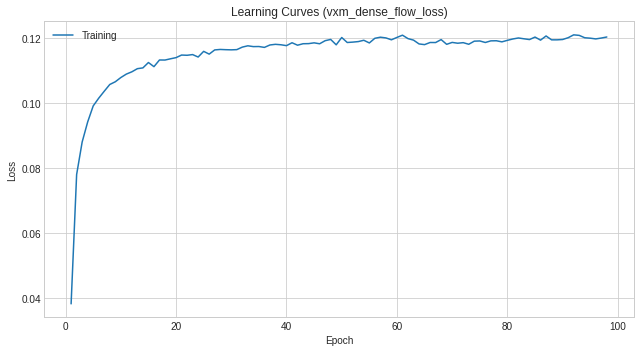

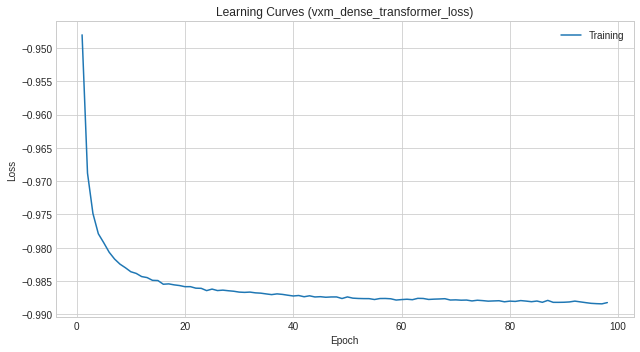

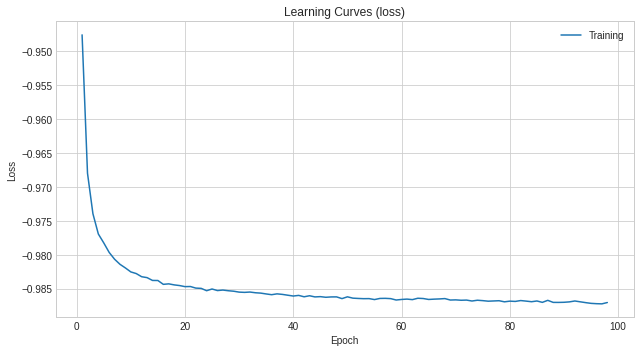

<Figure size 432x288 with 0 Axes>

33984/33984 [==============================] - 4533s 133ms/step - loss: -0.9870 - vxm_dense_transformer_loss: -0.9882 - vxm_dense_flow_loss: 0.1204
Epoch 99/2000
24645/33984 [====================>.........] - ETA: 20:44 - loss: -0.9871 - vxm_dense_transformer_loss: -0.9883 - vxm_dense_flow_loss: 0.1207

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



17509/33984 [==============>...............] - ETA: 36:34 - loss: -0.9872 - vxm_dense_transformer_loss: -0.9884 - vxm_dense_flow_loss: 0.1207

In [ ]:
with tf.device('GPU:1'):

    hist = vxm_model.fit(train_gen,
                         steps_per_epoch = Train_num * 64,
                         epochs=2000,
                         callbacks=[checkpointer, 
                                    csv_logger,
                                    early_stopping,
                                    plot_learning_curves_epoch
                                   ],
                        )

---

# 4. Inference Step & Image reconstruction


In [ ]:
log_df = pd.read_csv(os.path.join(save_model_path, r'log.csv'))
plot_learning_curve(log_df)
display.display(log_df.iloc[[log_df.val_loss.idxmin()]])

In [ ]:
best_epoch = log_df.loss.idxmin()
print(best_epoch)
vxm_model.load_weights(glob.glob(os.path.join(save_model_path, "weights_01577_-0.994.h5"))[0])


In [ ]:
val_subject_num = 1

In [ ]:
moving_patches , location_A = make_patches(V_moving[val_subject_num:val_subject_num+1],patch_size)
fixed_patches  , location_A = make_patches(V_fixed[val_subject_num:val_subject_num+1] ,patch_size)
                                                 

In [ ]:
with tf.device('GPU:0'):
    val_pred = vxm_model.predict([moving_patches,fixed_patches]);

In [ ]:
recon_image = np.zeros((512,512,192))
for loc_idx in range(len(location_A)):
    a_coor_A, b_coor_A = location_A[loc_idx][1] , location_A[loc_idx][2]  
    recon_image[a_coor_A:a_coor_A+patch_size,
                b_coor_A:b_coor_A+patch_size,...]= val_pred[0][loc_idx][...,0]
    
recon_image = np.swapaxes(recon_image[:512,:512,:],0,1)*10000
# recon_image =recon_image[:512,:512,:]*10000

print(recon_image.shape)
print(recon_image.max())
print(recon_image.min())

In [ ]:
slice_number = 170
moving = np.swapaxes(V_moving[val_subject_num][...,slice_number],0,1)*10000
fixed = np.swapaxes(V_fixed[val_subject_num][...,slice_number],0,1)*10000
predict = recon_image[:,:,slice_number]

In [ ]:
plt.figure(figsize= (20,40))
plt.subplot(1, 3, 1).axis('off')       
plt.imshow(moving,cmap='gray')

plt.subplot(1, 3, 2).axis('off')    
plt.imshow(fixed ,cmap='gray')
plt.subplot(1, 3, 3).axis('off')
plt.imshow(predict ,cmap='gray')
plt.show()

In [ ]:


from mpl_toolkits.axes_grid1 import make_axes_locatable


fig , (ax1,ax2,ax3) =plt.subplots(1, 3,figsize=(30,30))


z1_plot = ax1.imshow(moving,cmap='gray')
ax1.axis("off")

z2_plot = ax2.imshow(fixed ,cmap='gray')
ax2.axis("off")

z3_plot = ax3.imshow((norm(fixed) - norm(moving)),cmap='RdBu' ,vmin =- 0.5, vmax = 0.5 )
ax3.axis("off")
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(z3_plot, cax=cax)

plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig , (ax1,ax2,ax3) =plt.subplots(1, 3,figsize=(30,30))


z1_plot = ax1.imshow(predict,cmap='gray')
ax1.axis("off")

z2_plot = ax2.imshow(fixed ,cmap='gray')
ax2.axis("off")

z3_plot = ax3.imshow((norm(fixed) - norm(predict)),cmap='RdBu' ,vmin =- 0.5, vmax = 0.5 )
ax3.axis("off")
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(z3_plot, cax=cax)

plt.show()

---

# 5. Prediction Data Save & Result analysis

In [ ]:
nii_input = nib.load(val_D_paths[val_subject_num])
header = nii_input.header
new_image = nib.Nifti1Image(moving_data[val_subject_num],nii_input.affine, header)
nib.save(new_image,'moving_HCC_1765_D.nii')

In [ ]:
nii_input = nib.load(val_P_paths[val_subject_num])
header = nii_input.header
new_image = nib.Nifti1Image(fixed_data[val_subject_num],nii_input.affine, header)
nib.save(new_image,'fixed_HCC_1765_P.nii')

In [ ]:
recon_image = np.zeros((512,512,192))
for loc_idx in range(len(location_A)):
    a_coor_A, b_coor_A = location_A[loc_idx][1] , location_A[loc_idx][2]  
    recon_image[a_coor_A:a_coor_A+patch_size,
                b_coor_A:b_coor_A+patch_size,...]= val_pred[0][loc_idx][...,0]
    
# recon_image = np.swapaxes(recon_image[:512,:512,:],0,1)*10000
recon_image =recon_image[:512,:512,:]*10000

print(recon_image.shape)
print(recon_image.max())
print(recon_image.min())

In [ ]:
nii_input = nib.load(val_D_paths[val_subject_num])
z_slice = nii_input.get_fdata()
header = nii_input.header
new_image = nib.Nifti1Image(recon_image,nii_input.affine, header)
nib.save(new_image,'moved_HCC_1469_D.nii')